# SimCLR: Data Preparation

[A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf) by Ting Chen et al.


__Data Augmentation Details__

In our default pretraining setting (which is used to train our best models), we utilize:

- random crop (with resize and random flip)
- random color distortion
- random Gaussian blur

as the data augmentations.


A pseudo-code for color distortion using Pytorch is as follows:

```
from torchvision import transforms

def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p = 0.2)
    color_distort = transforms.Compose(
        [
            rnd_color_jitter,
            rnd_gray
        ])

    return color_distort
```


In [1]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle, imageio, cv2

# from resnet_bottleneck_block import resnet_block, ResNet50

/home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# print(torch.cuda.memory_summary())
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX TITAN X
Available device is cuda


In [4]:
# Specify training hyper-parameters-
batch_size = 64
num_epochs = 100

In [ ]:
'''
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        # A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        # A.HorizontalFlip(p = 0.5),
        # A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)
'''

In [ ]:
'''
jitter_strength = 1.0
inp_height = 96
gausian_blur = False

transform_train = A.Compose(
    [
        A.ColorJitter(
            brightness = 0.8 * jitter_strength,
            contrast = 0.8 * jitter_strength,
            saturation = 0.8 * jitter_strength,
            hue = 0.2 * jitter_strength,
            always_apply = False,
            p = 0.5
        ),
        A.RandomCrop(
            height = inp_height,
            width = inp_height,
            always_apply = False,
            p = 1.0
        ),
        
    ]
)
'''

In [ ]:
'''
jitter_strength = 1.0
inp_height = 96
gaussian_blur = True

train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(size = inp_height),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomApply(
            # brightness, contrast, saturation and hue-
            [transforms.ColorJitter(
                brightness = 0.8 * jitter_strength,
                contrast = 0.8 * jitter_strength,
                saturation = 0.8 * jitter_strength,
                hue = 0.2 * jitter_strength
            )],
            p = 0.8
        ),
        transforms.RandomGrayscale(p = 0.2),
        transforms.GaussianBlur(
            kernel_size = int(0.1 * inp_height),
            sigma = (0.1, 2.0)
        ),
        transforms.ToTensor()
    ]
)
'''

In [5]:
def training_transformations(
    jitter_strength = 1.0, inp_height = 96,
    gaussian_blur = False
):
    # Train data transformations-

    # brightness, contrast, saturation and hue-
    color_jitter = transforms.ColorJitter(
        brightness = 0.8 * jitter_strength,
        contrast = 0.8 * jitter_strength,
        saturation = 0.8 * jitter_strength,
        hue = 0.2 * jitter_strength
    )

    data_transforms = [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(size = inp_height),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomApply([color_jitter], p = 0.8),
        transforms.RandomGrayscale(p = 0.2)
    ]

    if gaussian_blur:
        data_transforms.append(transforms.GaussianBlur(kernel_size = int(0.1 * inp_height), sigma = (0.1, 2.0)))

    data_transforms.append(transforms.ToTensor())
    train_transform = transforms.Compose(data_transforms)

    return train_transform


In [6]:
train_transform = training_transformations(
    jitter_strength = 1.0, inp_height = 96,
    gaussian_blur = True
)

In [ ]:
"""
class STL10Dataset(Dataset):
    '''
    Custom STL-10 dataset only for unlabeled data!
    '''
    def __init__(self, root_dir, transform = None):
        super().__init__()
        
        self.root_dir = root_dir,
        self.transform = transform
    
    def __len__(self):
        totalFiles = 0
        totalDir = 0
        for base, dirs, files in os.walk(root_dir):
            # print(f'Searching in : {base}')
            for directories in dirs:
                totalDir += 1
            for Files in files:
                totalFiles += 1
        
        return totalFiles
    
    def __getitem__(self, idx):
        idx = idx + 1
        # image = imageio.v3.imread(self.root_dir[0] + "unlabeled_image_png_" + str(idx) + ".png")
        image = cv2.imread(self.root_dir[0] + "unlabeled_image_png_" + str(idx) + ".png")
        
        if self.transform is not None:
            img1 = self.transform(image)
            img2 = self.transform(image)
        
        return img1, img2

"""

In [7]:
class STL10UnlabeledDataset(Dataset):
    '''
    STL-10 dataset for unlabeled dataset.
    '''
    def __init__(self, path_to_data, transform = None):
        super().__init__()
        
        self.transform = transform
        
        # Read unlabeled data as .bin file-
        self.data = np.fromfile(path_to_data + "unlabeled_X.bin", dtype = np.uint8)
        
        # Reshape images as (C, H, W)-
        self.data = np.reshape(self.data, (-1, 3, 96, 96))
        
        # Rotate array by 90 degrees in the plane specified by axes-
        self.data = np.rot90(m = self.data, k = 3, axes = (2, 3))
        self.data = np.transpose(a = self.data, axes = (0, 2, 3, 1))
        
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        image = self.data[idx].copy()
        # print(len(image))
        
        if self.transform is not None:
            img1 = self.transform(image)
            img2 = self.transform(image)
            
            return img1, img2
    
    

In [8]:
# Specify STL-10 unlabeled data directory-
path_to_stl10 = "/home/majumdar/Downloads/.data/stl10_binary/"

In [9]:
# Create training data-
unlabeled_data = STL10UnlabeledDataset(
    path_to_data = path_to_stl10, transform = train_transform
)

In [10]:
print(f"# of unlabeled images in STL-10 dataset = {len(unlabeled_data)}")

# of unlabeled images in STL-10 dataset = 100000


In [11]:
# Create train loader-
train_loader = torch.utils.data.DataLoader(
    dataset = unlabeled_data, batch_size = batch_size,
    shuffle = True
)

In [12]:
# Sanity check-
x1, x2 = next(iter(train_loader))

In [13]:
x1.size(), x2.size()

(torch.Size([64, 3, 96, 96]), torch.Size([64, 3, 96, 96]))

In [14]:
# For visualization-
x1_vis = torch.permute(x1, (0, 2, 3, 1))
x2_vis = torch.permute(x2, (0, 2, 3, 1))

In [15]:
x1_vis.size(), x2_vis.size()

(torch.Size([64, 96, 96, 3]), torch.Size([64, 96, 96, 3]))

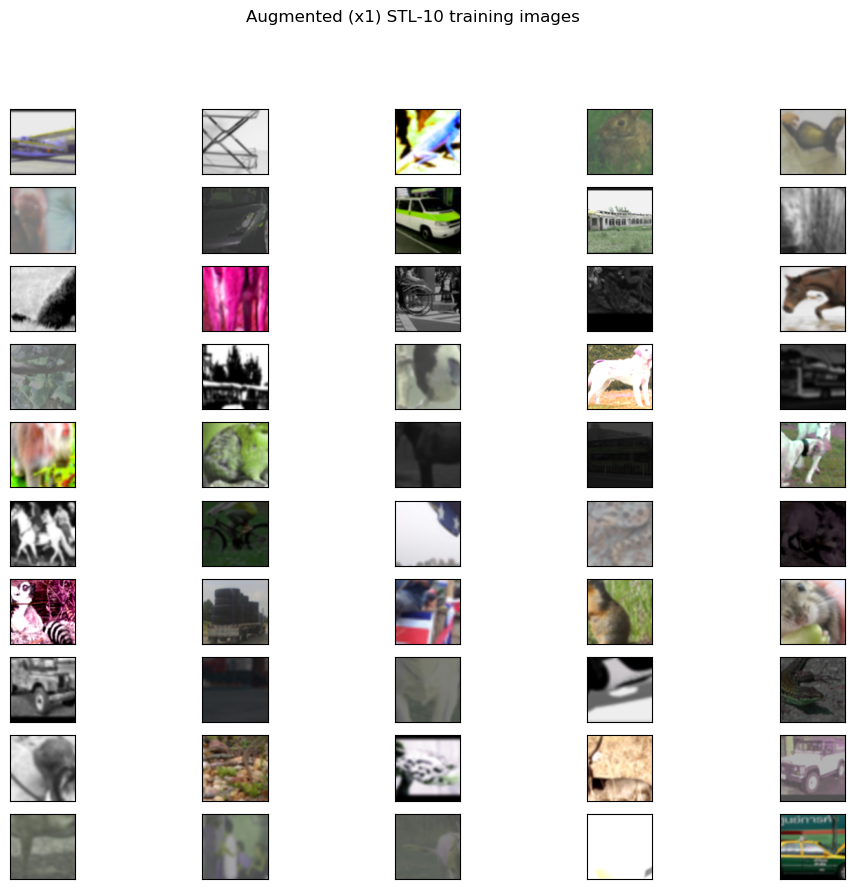

In [16]:
# Visualize SimCLR augmented images train images-
plt.figure(figsize = (12, 10))

for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.imshow(x1_vis[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Augmented (x1) STL-10 training images")
plt.show()

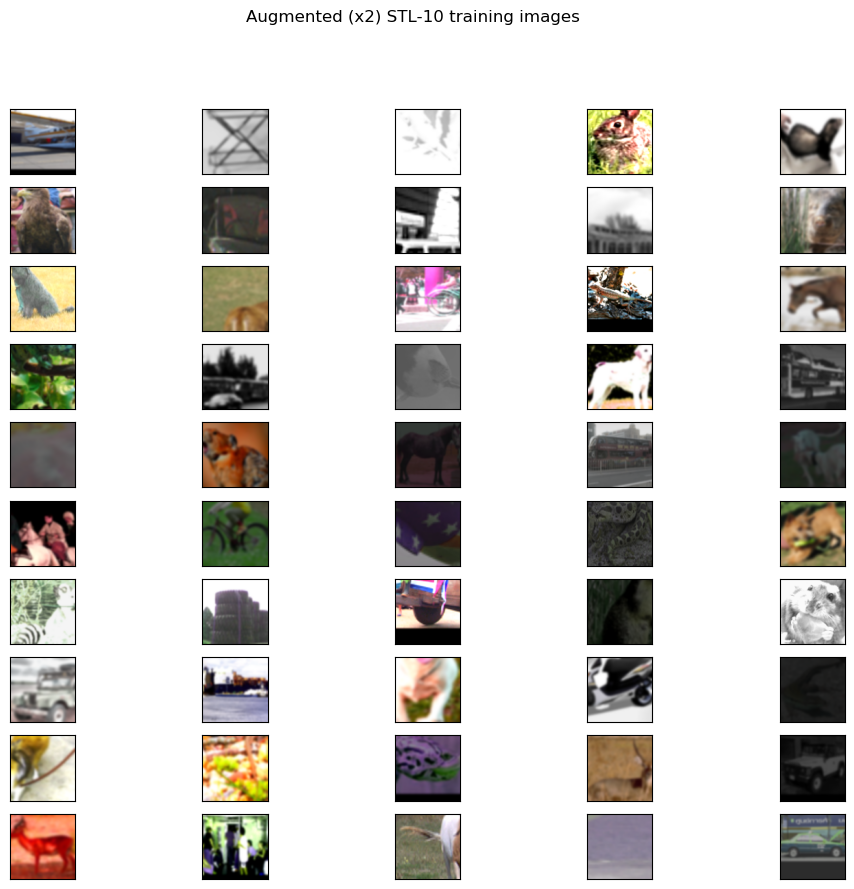

In [17]:
# Visualize SimCLR augmented images train images-
plt.figure(figsize = (12, 10))

for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.imshow(x2_vis[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Augmented (x2) STL-10 training images")
plt.show()

In [18]:
del x1, x2, x1_vis, x2_vis